In [1]:
import sys

sys.path.insert(0, r"/mnt/c/Users/Trez/Desktop/tudat-bundle/tudatpy/")
from tudatpy.data.mpc import BatchMPC
from tudatpy.data.horizons import HorizonsQuery

from tudatpy.numerical_simulation import environment_setup
from tudatpy.interface import spice

import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

from astroquery.mpc import MPC

import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from collections.abc import Iterable

import cartopy
from typing import Union, Tuple
import random
from astropy_healpix import HEALPix
import healpy
from astropy.units import Quantity
from astropy.time import Time

spice.load_standard_kernels()

In [2]:
lowres_folder = "debias_2018"
# highres_folder = "debias_2018"
bias_file = os.path.join(lowres_folder, "bias.dat")
tiles_file = os.path.join(lowres_folder, "tiles.dat")



In [3]:
tiles = pd.read_csv(
    tiles_file,
    sep=" ",
    skiprows=[0, 1],
    skipinitialspace=True,
    names=["tile_number", "RA", "DEC"],
)

print(tiles)

       tile_number        RA       DEC
0                0  0.785398  1.558038
1                1  2.356194  1.558038
2                2  3.926991  1.558038
3                3  5.497787  1.558038
4                4  0.392699  1.545280
...            ...       ...       ...
49147        49147  5.890486 -1.545280
49148        49148  0.785398 -1.558038
49149        49149  2.356194 -1.558038
49150        49150  3.926991 -1.558038
49151        49151  5.497787 -1.558038

[49152 rows x 3 columns]


In [4]:
print(["a", "b"] * 2)

['a', 'b', 'a', 'b']


In [5]:
catalog_flags = (
    "a",
    "b",
    "c",
    "d",
    "e",
    "g",
    "i",
    "j",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "t",
    "u",
    "v",
    "w",
    "L",
    "N",
    "Q",
    "R",
    "S",
    "U",
    "Y",
)


values = ["RA", "DEC", "PMRA", "PMDEC"]

m_index = pd.MultiIndex.from_product(
    [catalog_flags, values],
    names=["catalog", "value"],
)


bias = pd.read_csv(
    bias_file,
    sep=" ",
    skiprows=23,
    skipinitialspace=True,
    # header=[0, 1],
    # names=["tile_number", "RA", "DEC"],
    index_col=None,
    header=None,
    # names = m_index
    # names = (["RA", "DEC", "PMRA", "PMDEC"] * 26) + ["drop"]
).iloc[:, :-1]

bias.columns = m_index
# m_index = pd.MultiIndex(
#     levels=["catalog", "value"],
#     codes=[0, 1],
#     names=(
#         ["a", "b", "c", "d", "e", "g", "i", "j", "l", "m", "n", "o", "p", "q", "r", "t", "u", "v", "w", "L", "N", "Q", "R", "S", "U", "Y",],
#         ["RA", "DEC", "PMRA", "PMDEC"],
#     ),
# )
# bias.s(m_index)
# print(bias.columns)
print(bias.head(5))


catalog      a                         b                         c         \
value       RA    DEC  PMRA PMDEC     RA    DEC  PMRA PMDEC     RA    DEC   
0        0.279  0.326 -0.49 -1.04  0.287  0.336 -0.50 -1.01 -0.055 -0.075   
1        0.143 -0.224 -1.08  0.61  0.125 -0.224 -1.10  0.52 -0.136  0.084   
2       -0.139 -0.130  0.52  1.11 -0.134 -0.119  0.56  1.16 -0.031  0.189   
3       -0.334  0.213  1.16 -0.45 -0.342  0.206  1.19 -0.45  0.113 -0.017   
4        0.143  0.597  0.19 -1.30  0.153  0.601  0.34 -1.24  0.071 -0.072   

catalog  ...     S            U                         Y                     
value    ...  PMRA PMDEC     RA    DEC  PMRA PMDEC     RA    DEC  PMRA PMDEC  
0        ...  1.21 -0.29  0.009  0.014 -0.54 -0.90 -0.006 -0.005  0.40  0.37  
1        ...  2.32 -1.32  0.014 -0.010 -0.88  0.68 -0.008  0.004  0.54 -0.24  
2        ...  2.39  2.47 -0.010 -0.013  0.62  0.86 -0.004 -0.005  0.24  0.31  
3        ...  5.43  0.34 -0.016  0.009  1.02 -0.61 -0.001 -0.005 

In [6]:
tdeg = tiles.apply(np.degrees)

In [7]:
def plot_biases(mpc_flag, name, vminmax_pos, vminmax_mot):
    proj = cartopy.crs.Mollweide(central_longitude=0, globe=None)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        2, 2, subplot_kw={"projection": proj}, figsize=(9, 6.5)
    )
    for ax in fig.get_axes():
        ax.set_global()
    ax1.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].RA, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_pos, vmax=vminmax_pos)
    ax2.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].DEC, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_pos, vmax=vminmax_pos)
    ax3.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].PMRA, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_mot, vmax=vminmax_mot)
    ax4.scatter(x = -tdeg.RA, y=tdeg.DEC, marker=".", s=1, c=bias[mpc_flag].PMDEC, cmap=cm.jet, transform=cartopy.crs.Geodetic(), vmin=-vminmax_mot, vmax=vminmax_mot)

    for ax in fig.get_axes():
        # ax.set_extent([0, 180 + 360, -90, 90], crs=proj)
        ax.gridlines(draw_labels=False, dms=True, x_inline=True, y_inline=False)

    for ax in (ax1, ax2):
        label = r"$\Delta_{\alpha_{J_{2000}}}$[arcsec]"
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.05, axes_class=plt.Axes)
        plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=colors.Normalize(vmin=-vminmax_pos, vmax=vminmax_pos)), cax=cax, orientation="horizontal", label=label)
    for ax in (ax3, ax4):
        label = r"$\Delta_{\delta_{J_{2000}}}$[mas/yr]"
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.05, axes_class=plt.Axes)
        plt.colorbar(cm.ScalarMappable(cmap=cm.jet, norm=colors.Normalize(vmin=-vminmax_mot, vmax=vminmax_mot)), cax=cax, orientation="horizontal", label=label)

    ax1.set_title(f"{name}\nPosition Correction (RAcos(DEC))")
    ax2.set_title(f"{name}\nPosition Correction (DEC)")

    ax3.set_title(f"{name}\nProper Motion Correction (RAcos(DEC))")
    ax4.set_title(f"{name}\nProper Motion Correction (DEC)")
    plt.show()

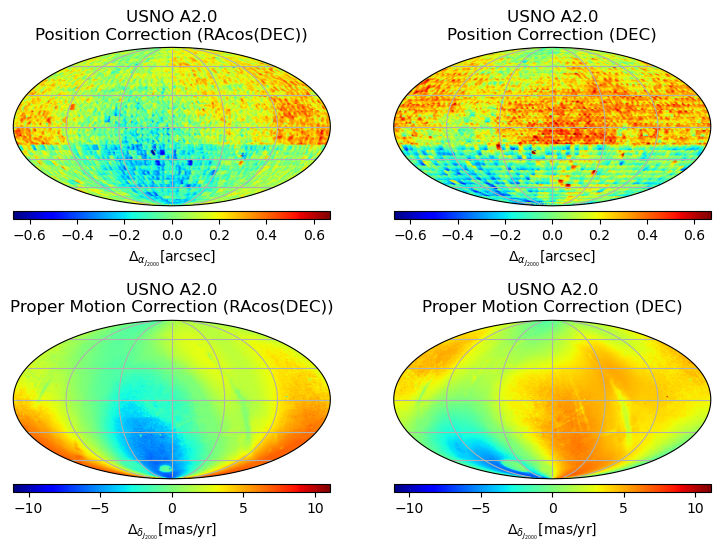

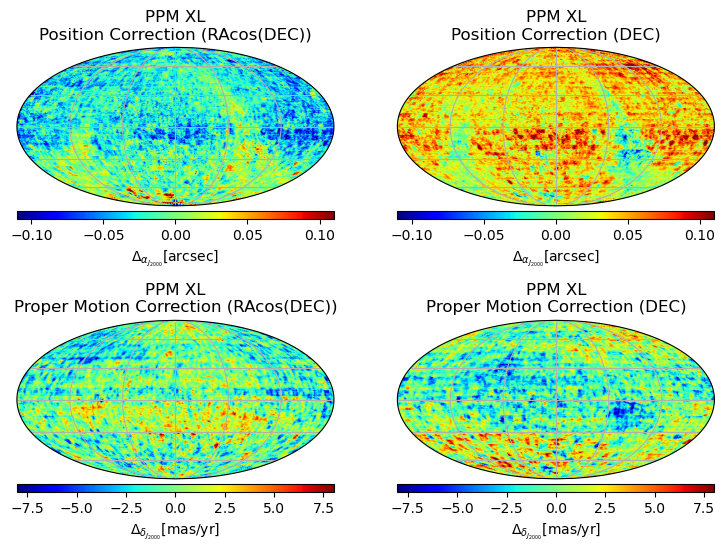

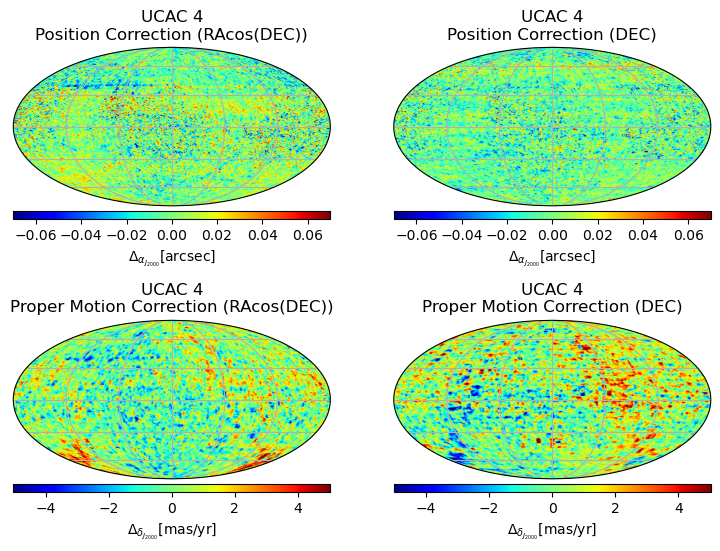

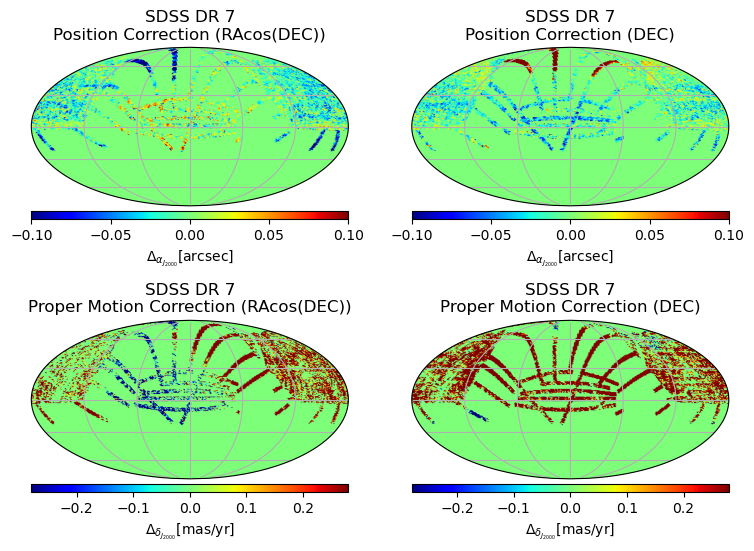

In [8]:
plot_biases("c", "USNO A2.0", vminmax_pos=0.67, vminmax_mot=11.07)
plot_biases("t", "PPM XL", vminmax_pos=0.11, vminmax_mot=8.03)
plot_biases("q", "UCAC 4", vminmax_pos=0.07, vminmax_mot=5.03)
plot_biases("N", "SDSS DR 7", vminmax_pos=0.1, vminmax_mot=0.28)

In [9]:
def load_bias_file(filepath):
    catalog_flags = (
        "a",
        "b",
        "c",
        "d",
        "e",
        "g",
        "i",
        "j",
        "l",
        "m",
        "n",
        "o",
        "p",
        "q",
        "r",
        "t",
        "u",
        "v",
        "w",
        "L",
        "N",
        "Q",
        "R",
        "S",
        "U",
        "Y",
    )

    values = ["RA", "DEC", "PMRA", "PMDEC"]

    m_index = pd.MultiIndex.from_product(
        [catalog_flags, values],
        names=["catalog", "value"],
    )

    bias_dataframe = pd.read_csv(
        filepath,
        sep=" ",
        skiprows=23,
        skipinitialspace=True,
        index_col=None,
        header=None,
    ).iloc[:, :-1]

    bias_dataframe.columns = m_index

    return bias_dataframe

load_bias_file(bias_file).head(5)
print(len(load_bias_file(bias_file)))

49152


In [26]:
def get_biases_ECFF18(
    RA: Union[float, np.ndarray, list],
    DEC: Union[float, np.ndarray, list],
    epochJ2000secondsTDB: Union[float, np.ndarray, list],
    catalog: Union[str, np.ndarray, list],
    use_highres=False,
    bias_file=bias_file,
) -> Union[tuple, np.ndarray]:

    # transform input to numpy arrays
    # for var in [RA, DEC, epochJ2000secondsTDB, catalog]:
    if not isinstance(RA, np.ndarray):
        RA = np.array([RA]).flatten()
    if not isinstance(DEC, np.ndarray):
        DEC = np.array([DEC]).flatten()
    if not isinstance(epochJ2000secondsTDB, np.ndarray):
        epochJ2000secondsTDB = np.array([epochJ2000secondsTDB]).flatten()
    if not isinstance(catalog, np.ndarray):
        catalog = np.array([catalog]).flatten()

    if not (len(RA) == len(DEC) == len(epochJ2000secondsTDB) == len(catalog)):
        raise ValueError("All inputs must have same size")

    # find nearest tile using HEALPix Algorithm and get indices
    # ideally nside should be retrieved from the load_bias_file function
    if use_highres:
        nside = 1
    else:
        nside = 64
    hp_obj = HEALPix(nside=nside)

    pixels = hp_obj.lonlat_to_healpix(
        Quantity(RA, unit="rad"), Quantity(DEC, unit="rad")
    )

    # load bias file
    # index matches the pixels
    # this is effectively a 3d table with axes: (pixel,( star catalog, value)) using pandas multiindex
    bias_df = load_bias_file(bias_file)

    # retrieve bias values from bias file using indices
    # result is N x 4 biases for the correct star catalog
    biases = np.zeros(shape=(len(RA), 4))
    catalogs = bias_df.columns.levels[0].to_list()
    for idx, (pix, cat) in enumerate(zip(pixels, catalog)):
        if cat not in catalogs:
            biases[idx] = 0.0
        else:
            biases[idx] = bias_df.loc[
                pix, (cat, ["RA", "DEC", "PMRA", "PMDEC"])
            ].to_numpy()

    # transform the values with formulas given, time in JD TT
    # def convert_table(time, bias_table, DEC):
    J2000_jd = 2451545.0
    epochs = (epochJ2000secondsTDB / 86400) + J2000_jd
    epochs = Time(epochs, format="jd", scale="tdb")
    # this was taken from find_orb -> bias.cpp
    epochs_years = (epochs.tt.value - J2000_jd) / 365.25

    RA_correction = (biases[:, 0] + (epochs_years * (biases[:, 2] / 1000))) / np.cos(
        DEC
    )
    DEC_correction = biases[:, 1] + (epochs_years * (biases[:, 3] / 1000))

    # convert from arcsec to radians
    RA_correction = RA_correction * (2 * np.pi)/1296000
    DEC_correction = DEC_correction * (2 * np.pi)/1296000

    return RA_correction, DEC_correction


# create test that hand verifies biases
# create test that checks if the pixels are correct

In [27]:
print(get_biases_ECFF18([1.00, 0.525], [1.00, 0.525], [0, 200], ["a", "c"]))
print(
    get_biases_ECFF18([1.00, 0.525], [1.00, 0.525], [757382400, 757382400], ["a", "c"])
)
print(get_biases_ECFF18(1.00, 0.545, 0, "c"))
print(get_biases_ECFF18(1.00, 0.545, 0, np.nan))

(array([3.94812344e-06, 7.45156970e-07]), array([-1.56110005e-06,  1.04234950e-06]))
(array([3.88351778e-06, 6.16071159e-07]), array([-1.49943175e-06,  1.35767223e-06]))
(array([-6.23644053e-08]), array([1.29930067e-06]))
(array([0.]), array([0.]))


In [39]:
b = BatchMPC()
b.get_observations(["433"])
print(len(b))
print(b.table.groupby("catalog").count().sort_values("RA", ascending=False).RA.sum())
print(b.table.groupby("catalog").count().sort_values("RA", ascending=False).RA.sum()/len(b) * 100, "%")
print(b.table.groupby("catalog").count().sort_values("RA", ascending=False).RA)

13697
8806
64.29145068263124 %
catalog
V    2565
q     950
u     940
c     884
r     800
p     432
o     395
z     323
m     313
L     266
U     149
d     136
g     132
l     113
w      96
R      84
i      59
t      57
a      53
X      22
v      17
A       6
C       4
Z       3
J       3
D       2
x       2
Name: RA, dtype: int64


In [40]:
RA_original = b.table.RA
DEC_original = b.table.DEC
time_original = b.table.epochJ2000secondsTDB
catalogs = b.table.catalog
# print(b.table.groupby("catalog").count().sort_values("RA"))
# catalogs = [random.choice(["t", "a", "c"]) for _ in RA_original]

RA_corr, DEC_corr = get_biases_ECFF18(RA_original, DEC_original, time_original, catalogs)

RA_corrected = RA_original - RA_corr
DEC_corrected = DEC_original - DEC_corr

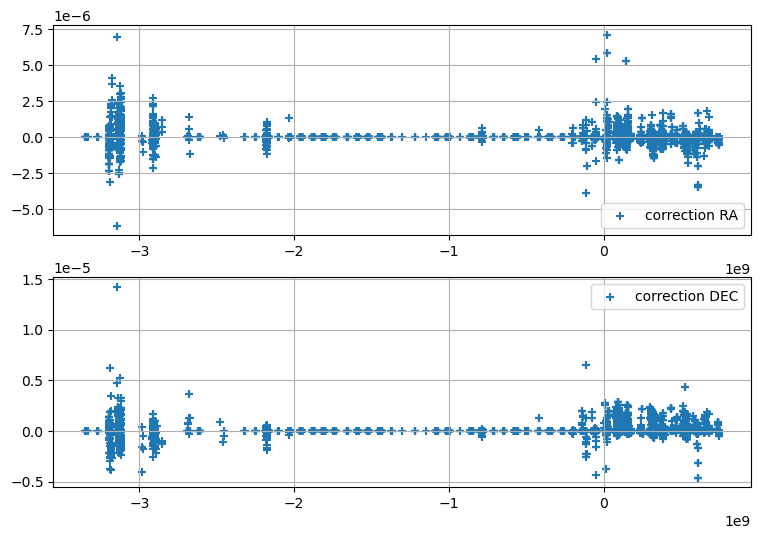

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))

ax1.scatter(time_original, RA_corr, marker="+", label="correction RA")
ax2.scatter(time_original, DEC_corr, marker="+", label="correction DEC")
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()

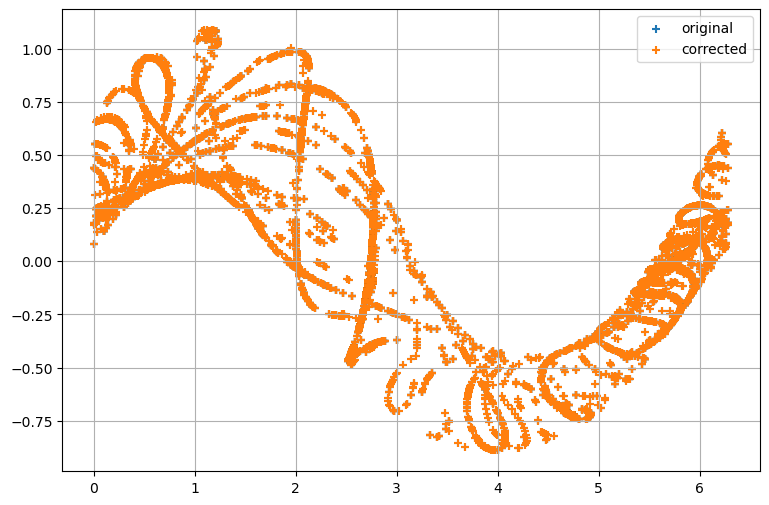

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.scatter(RA_original, DEC_original, marker="+", label="original")
ax.scatter(RA_corrected, DEC_corrected, marker="+", label="corrected")
ax.legend()
ax.grid()